In [1]:
#Imports
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import sklearn

import pyAudioAnalysis
import pydub
import ffmpeg

from numpy import sin, cos, pi, linspace, arange, log10, absolute
from numpy.random import randn
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter, freqz, welch
from scipy.io.wavfile import read , write
from scipy.signal import spectrogram
from matplotlib import pyplot as plt
from matplotlib.pyplot import ylabel, xlabel
from matplotlib.pyplot import plot, legend, show, grid, figure, savefig#, hold

In [6]:
import warnings

warnings.filterwarnings('ignore')

# Audio processing and analysis

In [3]:
# Load audio file
filename = 'C:/Users/lemos/PDS/TP/audio/training2/A_capa_01.wav'
fs, audio1 = read(filename)
f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

# Print audio data
print('filename: ', filename)
print('Data Length (s): ',t[-1])
print('Sampling frequency (samples/s): ', fs)

# Play Audio
ipd.Audio(filename)

filename:  C:/Users/lemos/PDS/TP/audio/training2/A_capa_01.wav
Data Length (s):  1.3
Sampling frequency (samples/s):  44100


Text(0, 0.5, 'frequency(Hz)')

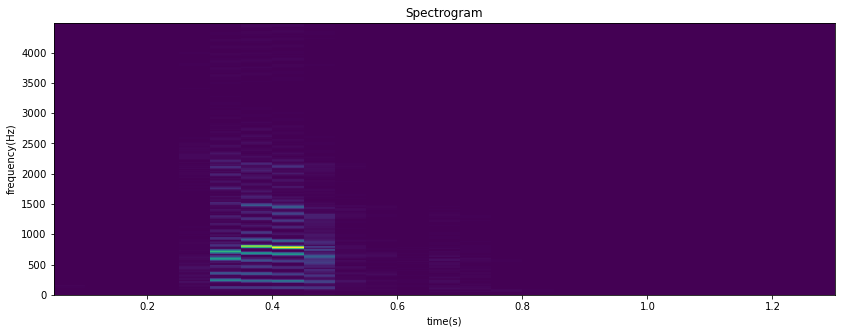

In [4]:
#Spectrogram 
plt.rcParams['figure.figsize'] = 14,5
plt.pcolormesh(t, f[:450], S1[:450][:]) 
plt.title("Spectrogram")
xlabel('time(s)')
ylabel('frequency(Hz)')

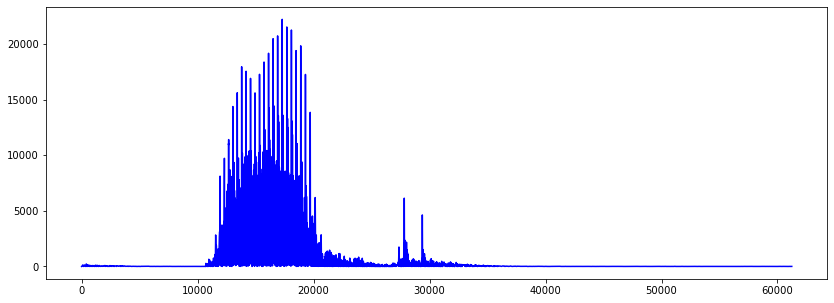

In [5]:
# ButterWord Filter
wn = 1500 / (fs/2)
b3, a3 = butter(4, wn)
audio1_filt = lfilter(b3, a3, audio1)

# Plot filtered audio
plt.rcParams['figure.figsize'] = 14,5
plot(absolute(audio1_filt),'b')

# Phonems segmentation





In the first part we showed how we can segment a long recording to non-overlapping segments using ffmpeg. The following code sample shows how to do the same with Python. Line 8 does the actual segmentation in a single-line command. Overall, the following script loads and normalizes an audio signal, and then it breaks it into 1-second segments and writes each one of them in a file.





(Pay attention to the note in the last comment: you will need to cast to 16bit before saving to file because the numpy conversion has led to higher sample resolutions).

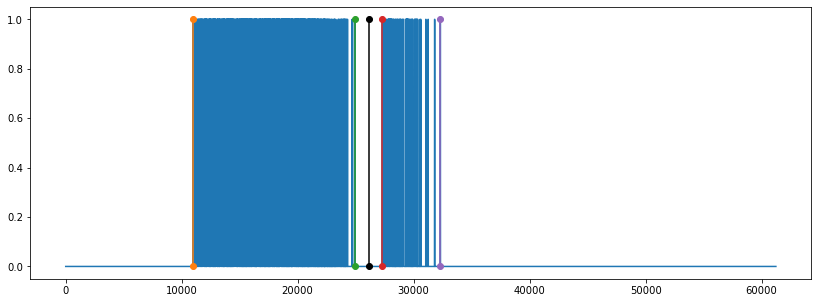

In [6]:
# Calculate Results
results = [1 if item > 0.001*1e8 else 0 for item in audio1_filt**2]

# Variables
x1 = x2 = 0
flag = False
coordinates = []
zeros_list = []
silence_len = 1000
change_len = 1000

# Find and segment phonemes
plot(results)
for i, result in enumerate(results):
    # First signal rise
    if(flag == False and result == 1 and x1 == 0):
        flag = True
        x1 = i
    # Check if signal fall is permanent
    if(flag == True):
        if(result == 0):
            zeros_list.append(result)
        else:
            zeros_list = []
    # Permanent signal fall
    if(flag == True and len(zeros_list) >= silence_len and x2 == 0):
        flag = False
        x2 = i - len(zeros_list)
        # If data is valid, save it in list
        if(not x2-x1 <= change_len):
            coordinates.append([x1, x2])
            plot([x1, x1], [0, 1], [x2, x2], [0, 1], marker='o')
        # Reset to initial state
        x1 = x2 = 0

# Get dividing point
pt1 = coordinates[0]
try:
    pt2 = coordinates[1]
    div_ptn = ((pt2[0] - pt1[1]) / 2) + pt1[1]
except:
    div_ptn = ((pt1[0] - pt1[1]) / 2)
    errors += 1

# Draw dividing line
plot([div_ptn, div_ptn], [0, 1], marker='o', color="black")

In [7]:
# Fix-sized segmentation (breaks a signal into non-overlapping segments)
signal = audio1 / (2**15)
signal_len = len(signal)
segment_size_t = 1 # segment size in seconds
segment_size = segment_size_t * fs  # segment size in samples

# Break signal into list of segments in a single-line Python code
segment1 = audio1[:int(div_ptn)]
segment2 = audio1[int(div_ptn):]
segments = [segment1, segment2]

# Save each segment in a seperate filename
for iS, s in enumerate(segments):
    write("C:/Users/lemos/PDS/TP/audio/data/chunky{0:d}.wav".format(segment_size_t * iS, segment_size_t * (iS + 1)), fs, (s))

In [8]:
# Read phoneme
filename = 'C:/Users/lemos/PDS/TP/audio/data/chunky0.wav'
fs, chunky1 = read(filename)
f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

# Print info
print('filename: ', filename)
print('Data Length (s): ',t[-1])
print('Sampling frequency (samples/s): ', fs)

#Play Audio
ipd.Audio(filename)


filename:  C:/Users/lemos/PDS/TP/audio/data/chunky0.wav
Data Length (s):  1.3
Sampling frequency (samples/s):  44100


Text(0, 0.5, 'frequency(Hz)')

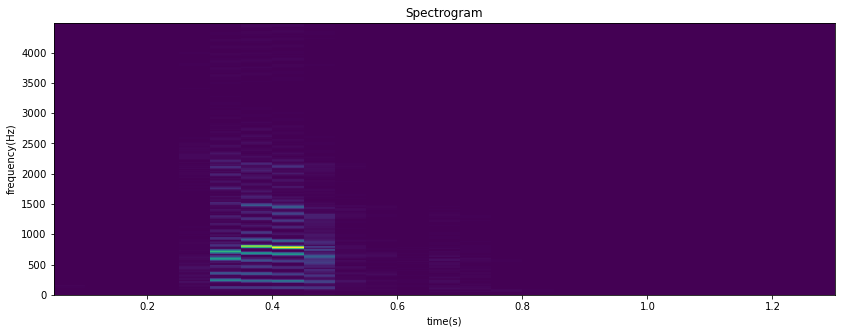

In [9]:
#Spectrogram 
plt.rcParams['figure.figsize'] = 14,5
plt.pcolormesh(t, f[:450], S1[:450][:])
plt.title("Spectrogram")
xlabel('time(s)')
ylabel('frequency(Hz)')

# MFCC

In [60]:
filename = 'C:/Users/lemos/PDS/TP/audio/data/chunky0.wav'
signal, fs = librosa.load(filename) 

# get audio mfccs
mfccs = librosa.feature.mfcc(signal, sr=fs, n_mfcc=40, n_fft = 1024, hop_length = 50, n_mels = 130,  fmin = 10, fmax = 4000)
mfccs.shape

### Normalize mfcc results

In [11]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

[ 2.9119827e-08  0.0000000e+00  0.0000000e+00  2.9119827e-08
 -2.9119827e-08  0.0000000e+00  0.0000000e+00  1.4559913e-08
 -1.4559913e-08  0.0000000e+00  2.9119827e-08 -1.4559913e-08
  0.0000000e+00  0.0000000e+00  5.8239653e-08  0.0000000e+00
  0.0000000e+00  1.4559913e-08 -5.0049702e-09  0.0000000e+00
  0.0000000e+00  7.2799566e-09 -1.4559913e-08  0.0000000e+00
 -7.2799566e-09 -1.4559913e-08  1.4559913e-08  0.0000000e+00
  0.0000000e+00  2.9119827e-08  0.0000000e+00  0.0000000e+00
  2.9119827e-08  0.0000000e+00  0.0000000e+00  1.4559913e-08
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -2.9119827e-08]
[1.0000001 1.        1.        0.9999999 0.9999999 1.0000001 1.0000001
 1.        1.0000002 1.        1.        1.        1.0000001 1.
 0.9999999 1.        1.        1.        0.9999999 1.0000001 1.
 1.0000002 1.        1.        1.        1.0000001 1.        1.
 1.        0.9999999 1.        1.        1.        0.9999999 1.
 1.        1.        1.0000002 1.        1.0000001]


### Visualize MFCC

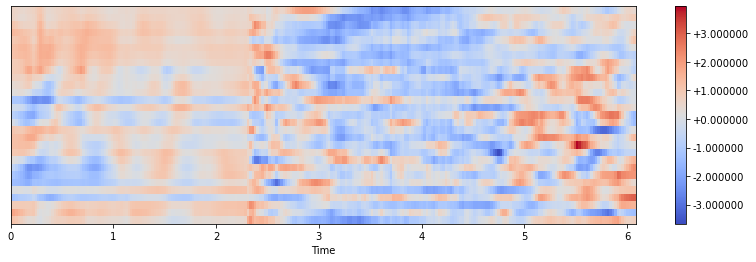

In [12]:
plt.figure(figsize=(14,4))

# Display mfcc values
librosa.display.specshow(mfccs[1:][10:], x_axis='time', sr=fs)
plt.colorbar(format="%+2f")
plt.show()

#Play Audio
ipd.Audio(filename)

### Calculate delta and delta2 MFCCs

In [13]:
delta_mfccs=librosa.feature.delta(mfccs)
delta2_mfccs=librosa.feature.delta(mfccs, order=2)
print(delta_mfccs.shape)
print(mfccs.shape)

(40, 262)
(40, 262)


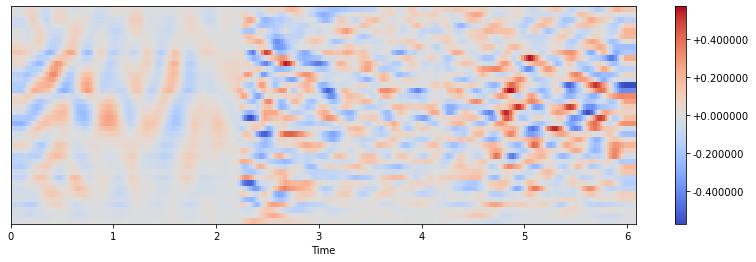

In [14]:
#First Derivative of MFCCs
plt.figure(figsize=(14,4))
librosa.display.specshow(delta_mfccs,x_axis='time',sr=sr)
plt.colorbar(format="%+2f")
#plt.show()
#plot(delta_mfccs)

    #mfccs = np.mod(mfccs)
    #mfccs = np.abs(mfccs)
    
     #Correlation
    #df.corr(method = 'pearson')
    #value = pd.DataFrame(signal)
    #dataframe = pd.concat([value.shift(3),value.shift(2),value.shift(1), values], axis=1)
    #results = dataframe.corr(method = 'pearson')
    #mfccs = results 
    

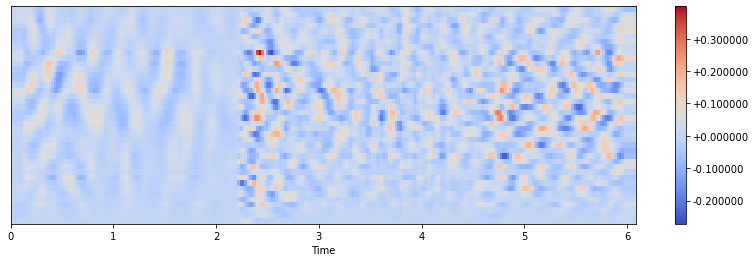

In [15]:
#Second Derivatives of MFCCs
plt.figure(figsize=(14,4))
librosa.display.specshow(delta2_mfccs, x_axis='time', sr=fs)
plt.colorbar(format="%+2f")

# Read and calculate MFCC for all segmented phonemes

In [174]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


directory = 'C:/Users/Dasil/1. Processamento Digital do Sinal/Project/audio/WD_data/'
mfcc_data = []
temp_list = []

for file in os.listdir(directory):
    # Get audio file
    filename = os.path.join(directory, file)
    # Load audio
    signal, fs = librosa.load(filename)
    
    # Calculate MFCCs
    mfccs = librosa.feature.mfcc(signal, sr=fs, n_mfcc=40, n_fft = 1024, hop_length = 50, n_mels = 1000,  fmin = 10, fmax = 4000)
    mfccs = np.average(mfccs, axis=1)
    #mfccs = np.average(np.average(mfccs, axis=1))
    # Make it into a one-dimensional array
    #mfccs = mfccs.flatten()
    mfccs = mfccs.tolist()
    #mfccs.insert(1, mfccs[0])
    # Delete the features of mfcc after the 1st and 14th dimensions because they are not needed.

    mfccs.pop(0)
    #mfccs = mfccs[:12]
    #mfccs = mfccs[25:]
    mfccs = mfccs[:18]
    
    # Insert label
    file = file.replace('.wav', '')
    file_parts = file.split('_')
    word = file_parts[1]
    if (len(word) > 4):
        if(file_parts[-1] == '0'):
            phoneme = word[0:3]
        else:
            phoneme = word[3:]
    else:
        if(file_parts[-1] == '0'):
            phoneme = word[0:2]
        else:
            phoneme = word[2:]
    temp_list.append(phoneme)
    mfccs.insert(0, phoneme)
    mfcc_data.append(mfccs)   
    
temp_list = list(dict.fromkeys(temp_list))
print(temp_list)
print(len(temp_list))

['ca', 'pa', 'sa', 'ta', 've', 'cha', 'chu', 'va', 'far', 'da', 'la', 'ri']
12


In [175]:
# Dataset loading
df = pd.DataFrame(mfcc_data)

x = df.iloc[:,1:] # MFCC features
y = df.iloc[:,0] # Phoneme label

# Label changed to number once
label = set(y)
label_list = list(label)
label_list.sort()
for i in range(len(label_list)):
    y[y == label_list[i]] = i
y = np.array(y, dtype = "int")

# Preview dataframe
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,76.980934,-45.676857,8.894008,-2.018707,-19.021029,4.078867,2.000490,-0.955643,-12.272935,-10.050838,1.352534,-9.280267,-4.449166,0.391313,-7.512781,-1.230856,-0.695866,-4.022811
1,6,63.365211,0.870459,5.295862,8.352122,-2.123876,-0.754201,6.334206,4.146660,-4.152362,-0.602186,3.296966,-0.830556,-0.734308,-0.245619,-0.639805,-0.869522,-1.895563,-0.176186
2,0,58.115437,-37.482723,8.420927,-1.823041,-15.595912,4.106684,1.825103,0.096113,-6.494258,-6.651713,0.097771,-6.251100,-2.841483,-0.147762,-5.985523,-1.864730,-0.578552,-2.961632
3,6,94.816544,-13.018181,0.418370,10.959591,-7.070400,-6.596722,7.068066,5.973570,-7.593128,-1.440232,4.262571,-2.652404,-1.065754,-1.627485,-1.783806,1.199725,-0.484503,0.934696
4,0,62.466553,-3.935321,31.114330,-6.276702,-12.827645,1.805373,-9.069100,-1.330639,4.499133,2.200958,2.172522,4.970256,-0.730620,-6.130054,-2.107802,-3.364533,-0.825150,1.196010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,6,92.571640,-10.867955,-4.683212,8.487161,-4.259295,-8.631003,3.348605,8.645637,-1.283468,-1.244580,-0.443306,-2.903652,-1.618376,-5.845047,-4.105176,-0.616513,-2.090036,-0.977944
224,7,82.868843,1.137845,16.804502,0.638563,-4.948668,0.214515,-2.834293,-2.357483,-2.613857,3.250469,2.005528,-2.775364,-0.159555,-1.166824,-5.369340,-3.176508,-0.564544,-1.561931
225,9,84.130974,-13.607295,-1.245872,7.339179,-11.594885,-6.533117,8.039737,3.106106,-3.188068,2.723339,0.555278,-5.118267,-3.813774,-2.610121,-3.411049,-3.357655,-1.140911,-1.469076
226,7,81.350487,3.014408,15.287148,2.601802,-3.658437,-1.901661,-2.712412,-4.170580,-3.967680,4.288017,-0.614951,-4.627439,1.525189,-4.093142,-7.893166,-1.847794,-2.440613,-0.712475


### Train classifier

In [173]:
# Determine the train data and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
print(f'Train: {x_train.shape}\nTest: {x_test.shape}\n')

# Data standardization
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

# Instantiate an SVM
model_linear = SVC(kernel='linear', random_state=1)
model_poly = SVC(kernel='poly', random_state= 1)
model_rbf = SVC(kernel='rbf', random_state=1)
# Fit models
model_linear.fit(x_train_std, y_train)
model_poly.fit(x_train_std, y_train)
model_rbf.fit(x_train_std, y_train)

# ===== Train data =====
# Predictions
pred_linear_train = model_linear.predict(x_train_std)
pred_poly_train = model_poly.predict(x_train_std)
pred_rbf_train = model_rbf.predict(x_train_std)
# Accuracy scores
accuracy_linear_train = accuracy_score(y_train, pred_linear_train)
accuracy_poly_train = accuracy_score(y_train, pred_poly_train)
accuracy_rbf_train = accuracy_score(y_train, pred_rbf_train)

#print('Train result')
#print(f'Linear : {int(accuracy_linear_train*100)}%')
#print(f'Poly : {int(accuracy_poly_train*100)}%')
#print(f'RBF : {int(accuracy_rbf_train*100)}%')
#print("-" * 15)

# ===== Test data =====
# Predictions
pred_linear_test = model_linear.predict(x_test_std)
pred_poly_test = model_poly.predict(x_test_std)
pred_rbf_test = model_rbf.predict(x_test_std)
# Accuracy scores
accuracy_linear_test = accuracy_score(y_test, pred_linear_test)
accuracy_poly_test = accuracy_score(y_test, pred_poly_test)
accuracy_rbf_test = accuracy_score(y_test, pred_rbf_test)

#print('Test result')
#print(f'Linear : {int(accuracy_linear_test*100)}%')
#print(f'Poly : {int(accuracy_poly_test*100)}%')
#print(f'RBF : {int(accuracy_rbf_test*100)}%')

# Create dataframe
data = {'Train result':[accuracy_linear_train*100, accuracy_poly_train*100, accuracy_rbf_train*100],
        'Test result': [accuracy_linear_test*100, accuracy_poly_test*100, accuracy_rbf_test*100]}
df_results = pd.DataFrame(data)
# Change the row indexes
df_results.index = ['Linear', 'Poly', 'RBF']
df_results.round(decimals=2)

Train: (159, 18)
Test: (69, 18)

Train result
Linear : 85%
Poly : 71%
RBF : 76%
----------------------------------------
Test result
Linear : 43%
Poly : 44%
RBF : 55%


,Train result,Test result
Linear,98.66,52.70
Poly,62.42,40.54
RBF,82.55,52.70


In [62]:
mfccs_temp = librosa.feature.mfcc(signal, sr=fs, n_mfcc=40, n_fft = 1024, hop_length = 50, n_mels = 130,  fmin = 10, fmax = 4000)
mfccs_temp = np.average(mfccs, axis = 1)
# Make it into a one-dimensional array
mfccs_temp = mfccs.flatten()
mfccs_temp = mfccs.tolist()
# Delete the features of mfcc after the 1st and 14th dimensions because they are not needed.
mfccs_temp.pop(0)
mfccs_temp.insert(0, 0)

x_temp = df.iloc[:,1:] # MFCC features
# Data standardization
sc = StandardScaler()
sc.fit(x_temp)
x_test_std = sc.transform(x_temp)

phoneme1 = model_linear.predict(x_test_std)
#phoneme2 = model_linear.predict(temp)
temp = list(dict.fromkeys(temp))
print(temp)

AxisError: axis 1 is out of bounds for array of dimension 1

# Decision Tree Classifier with criterion gini index

In [19]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Instantiate the DecisionTreeClassifier model with criterion gini index
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=0)

# Fit the model
clf_gini.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

### Predict the Test set results with criterion gini index

In [20]:
y_pred_gini = clf_gini.predict(x_test)
print('Model accuracy score with criterion gini index: {0:0.4f}'.format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.4186


### Compare the train-set and test-set accuracy

In [21]:
y_pred_train_gini = clf_gini.predict(x_train)
print('Training-set accuracy score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 1.0000


### Check for overfitting and underfitting

In [22]:
# Print the scores on training and test set
print('Training set score: {:.4f}'.format(clf_gini.score(x_train, y_train)))
print('Test set score: {:.4f}'.format(clf_gini.score(x_test, y_test)))

# If the different between the train and test exceeds 5%, the model is considered overfitted 
if (clf_gini.score(x_train, y_train) - clf_gini.score(x_test, y_test) > 0.05):
    print('\nThe models is over fitted')

Training set score: 1.0000
Test set score: 0.4186

The models is over fitted


### Visualize decision-trees 

[Text(0.36904761904761907, 0.9444444444444444, 'X[14] <= -3.024\ngini = 0.702\nsamples = 87\nvalue = [8, 5, 32, 2, 33, 7]'),
 Text(0.1746031746031746, 0.8333333333333334, 'X[19] <= -7.546\ngini = 0.563\nsamples = 36\nvalue = [4, 1, 8, 0, 22, 1]'),
 Text(0.06349206349206349, 0.7222222222222222, 'X[34] <= -4.468\ngini = 0.642\nsamples = 9\nvalue = [4, 0, 3, 0, 2, 0]'),
 Text(0.031746031746031744, 0.6111111111111112, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3, 0, 0, 0]'),
 Text(0.09523809523809523, 0.6111111111111112, 'X[18] <= -1.748\ngini = 0.444\nsamples = 6\nvalue = [4, 0, 0, 0, 2, 0]'),
 Text(0.06349206349206349, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 0, 0, 2, 0]'),
 Text(0.12698412698412698, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [4, 0, 0, 0, 0, 0]'),
 Text(0.2857142857142857, 0.7222222222222222, 'X[37] <= -3.619\ngini = 0.414\nsamples = 27\nvalue = [0, 1, 5, 0, 20, 1]'),
 Text(0.2222222222222222, 0.6111111111111112, 'X[29] <= -1.501\ngini = 0.58\nsamples = 10\nvalue = [0, 0,

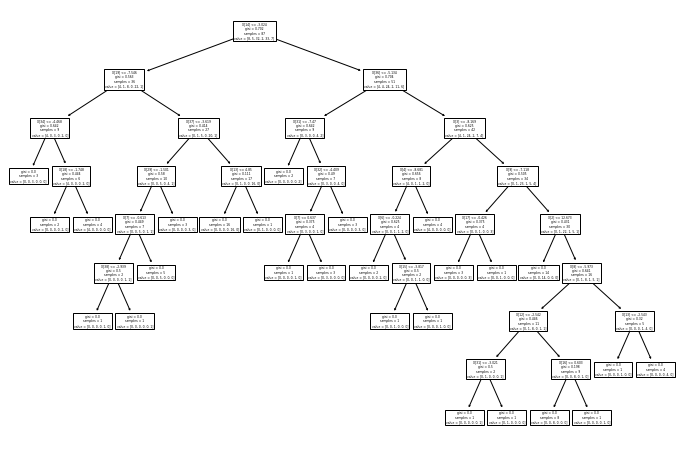

In [23]:
plt.figure(figsize=(12,8))
tree.plot_tree(clf_gini.fit(x_train, y_train))

# Decision Tree Classifier with criterion entropy

In [24]:
from sklearn.metrics import accuracy_score
from sklearn import tree

# instantiate the DecisionTreeClassifier model with criterion entropy
clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

# fit the model
clf_en.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

### Predict the Test set results with criterion entropy

In [25]:
y_pred_en = clf_en.predict(x_test)
print('Model accuracy score with criterion entropy: {0:0.4f}'.format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy: 0.3488


### Compare the train-set and test-set accuracy

In [26]:
y_pred_train_en = clf_en.predict(x_train)
print(y_pred_train_en)
print('Training-set accuracy score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train_en)))

[4 4 4 4 2 4 2 0 1 0 4 4 4 2 2 4 2 1 2 3 4 4 4 4 4 4 3 4 4 4 0 4 4 4 4 2 2
 2 0 0 4 4 1 4 2 0 4 0 4 4 0 0 4 4 2 2 1 4 4 2 4 4 4 4 4 4 4 4 4 2 4 4 4 4
 4 2 4 2 4 4 2 4 4 4 4 4 4]
Training-set accuracy score: 0.6437


### Check for overfitting and underfitting

In [27]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(clf_en.score(x_train, y_train)))
print('Test set score: {:.4f}'.format(clf_en.score(x_test, y_test)))

# If the different between the train and test exceeds 5%, the model is considered overfitted 
if (clf_gini.score(x_train, y_train) - clf_gini.score(x_test, y_test) > 0.05):
    print('\nThe models is over fitted')

Training set score: 0.6437
Test set score: 0.3488

The models is over fitted


### Visualize decision-trees

[Text(0.5, 0.875, 'X[36] <= 1.874\nentropy = 2.032\nsamples = 87\nvalue = [8, 5, 32, 2, 33, 7]'),
 Text(0.25, 0.625, 'X[5] <= 7.901\nentropy = 1.747\nsamples = 70\nvalue = [1, 5, 28, 0, 29, 7]'),
 Text(0.125, 0.375, 'X[7] <= 8.542\nentropy = 1.633\nsamples = 54\nvalue = [1, 1, 26, 0, 19, 7]'),
 Text(0.0625, 0.125, 'entropy = 1.604\nsamples = 43\nvalue = [0, 1, 16, 0, 19, 7]'),
 Text(0.1875, 0.125, 'entropy = 0.439\nsamples = 11\nvalue = [1, 0, 10, 0, 0, 0]'),
 Text(0.375, 0.375, 'X[15] <= -6.684\nentropy = 1.299\nsamples = 16\nvalue = [0, 4, 2, 0, 10, 0]'),
 Text(0.3125, 0.125, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4, 0, 0, 0, 0]'),
 Text(0.4375, 0.125, 'entropy = 0.65\nsamples = 12\nvalue = [0, 0, 2, 0, 10, 0]'),
 Text(0.75, 0.625, 'X[9] <= 2.675\nentropy = 1.873\nsamples = 17\nvalue = [7, 0, 4, 2, 4, 0]'),
 Text(0.625, 0.375, 'X[4] <= -8.953\nentropy = 1.42\nsamples = 13\nvalue = [7, 0, 2, 0, 4, 0]'),
 Text(0.5625, 0.125, 'entropy = 1.0\nsamples = 4\nvalue = [0, 0, 2, 0, 2, 0]'),


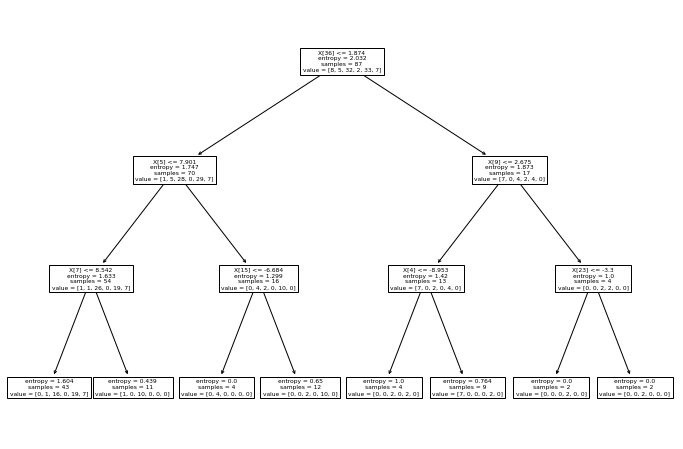

In [28]:
plt.figure(figsize=(12,8))
tree.plot_tree(clf_en.fit(x_train, y_train))

# Confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix

# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred_en)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 0  0  1  3  0]
 [ 0  0  1  0  0]
 [ 2  0  4 12  0]
 [ 0  1  5 11  0]
 [ 0  0  0  3  0]]


# Classification Report

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_en))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.36      0.22      0.28        18
           4       0.38      0.65      0.48        17
           5       0.00      0.00      0.00         3

    accuracy                           0.35        43
   macro avg       0.15      0.17      0.15        43
weighted avg       0.30      0.35      0.30        43

